In [361]:
import sys
#!{sys.executable} -m pip install pandas
#!{sys.executable} -m pip install scikit-beam
#!{sys.executable} -m pip install numba

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit as fit
import scipy.sparse as sci_sparse
import os

from dls_data_extraction import*

#%matplotlib notebook

In [362]:
date = '2021-12-05' # NP in water
#date = '2021-12-06' # NP in dmso-water
datadir = './tmp/'+date+'/' # sample data directory

In [363]:
solvent = 'water'
sample = '100NP_'
#scans = range(7587,7597)    # scans to run -- NP in water/DMSO in focus
#scans = range(7607,7617)    # scans to run -- NP in water/DMSO 1000um out
#scans = range(7637,7667)    # scans to run -- NP in water/DMSO 2000um out
scans = range(252,552)       # scans to run -- NP in water in focus
exp_time = 5e-7              # exposure time [s]
downsample = 10              # pixel binning
#width = 1

filename = str(scans)+'_'+str(downsample)+'x'+str(downsample)+'_'+str(exp_time)+'s' #+'_width'+str(width)

g2 = np.load(datadir+sample+solvent+'_g2_'+filename+'.npy')
g2av = np.load(datadir+sample+solvent+'_g2av_'+filename+'.npy')
g2std = np.load(datadir+sample+solvent+'_g2std_'+filename+'.npy')
q = np.load(datadir+sample+solvent+'_q_'+filename+'.npy') # 1/Å
delays = np.load(datadir+sample+solvent+'_delays_'+filename+'.npy') # s
print(g2av.shape, g2.shape, q)

# experimental parameters
distance = 4.0 # m
photon_energy = 10.0e3 #eV
h = 4.135667516e-15
c = 2.99792458e8
wavelength = h*c/photon_energy
pix = 55e-6 # pixel size, m

(399, 20) (300, 399, 20) [0.05676936 0.06032793 0.06427809 0.06688745 0.07111541 0.07451499
 0.07851204 0.08113534 0.08475168 0.0883943  0.09212257 0.09525666
 0.09889776 0.1022169  0.10566486 0.1091241  0.11287018 0.11589713
 0.11943115 0.12309645]


## Plot all g2 

## Plot average g2

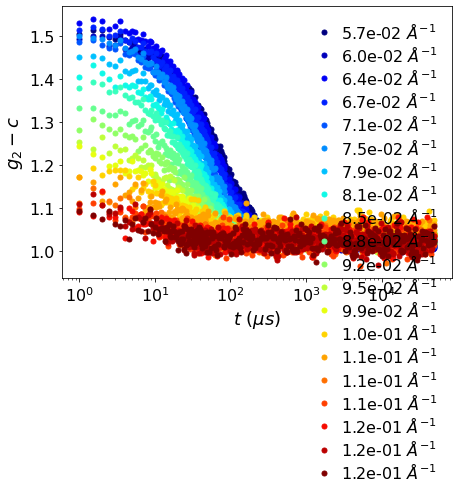

In [364]:
t = delays*exp_time * 1.0e6 # delay time [us]

plt.figure(figsize=(7,5))
col = plt.cm.jet(np.linspace(0,1,len(q)))

for i in range(0,len(q)):
    
    l, = plt.plot(t[1:], g2av[1:, i], 'o', alpha=1.0, ms=5 , color=col[i], label=r'%.1e $\AA^{-1}$' %q[i])
    #plt.errorbar(t[1:], g2av[1:, i], yerr=g2std[1:, i], color=l.get_color(), fmt='o', ms=3 ) #,label=r'%.1e $\AA^{-1}$' %q[i])
    
plt.xlabel('$t ~(\mu s)$', size=18)
plt.ylabel(r'$g_2-c$', size=18)
plt.xscale('log', nonpositive='clip')
plt.legend(frameon=False, loc='upper right', fontsize=16, labelspacing=0.2, handletextpad=0.1)
plt.tick_params(labelsize=16)

plt.show()

## Fit g2 and plot

44.91242564173888
52.29744498299846
61.32405448556333
69.77889272569925
77.35115362405445
87.36313308178282
92.84927165022535
106.94385289754742
114.30545576373476
132.59212228836068
147.02681867662096
contrast: [0.19360059647347885, 0.2197805576912435, 0.2680051745661163, 0.30844489222913646, 0.35646730853328107, 0.38992571042521457, 0.41984136914464626, 0.4643615401888108, 0.47055425132775486, 0.4934276846499262, 0.509882328714025]


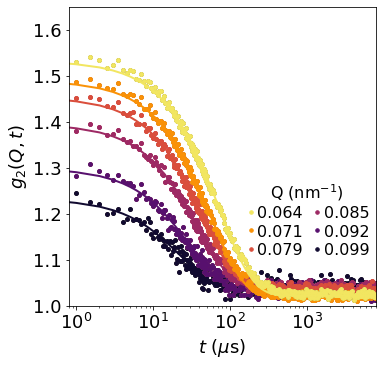

In [365]:
from scipy.special import gamma, polygamma
from scipy.optimize import curve_fit

def exponential(x, a , b):
    return np.abs(a)*np.exp(-2*x/np.abs(b)) #+ baseline

def stretched_exponential(x, a , b, c):
    return np.abs(a)*np.exp(-2*(x/np.abs(b))**c) #+ baseline

fun = 1 # choose fit function

if fun == 1:
    fit_func = exponential
elif fun == 2:
    fit_func = stretched_exponential
elif fun == 3:
    fit_func = exponential2
    
N=7 # no of high q values to omit

col = plt.cm.inferno_r(np.linspace(-0.1,1,len(q)+1-N))

plt.figure(figsize=(5.5,5.5)) # for paper

tstart = 1
tau = []
tau_errors = []
kww = []
kww_errors = []
qs = []
qind = []
beta=[]
beta_errors=[]
unit = 1e6
t = delays*exp_time * unit # delay time [us]
tt = np.concatenate((np.linspace(0,1,10), np.logspace(0,5,200).astype(int)), axis=None)*1e-6*unit

p = np.arange(2,len(q)-N) # for plotting
u=0 # for plotting

for i in range(len(q)-N-1,1,-1): # plot decreasing q
    
    bg = np.nanmean(g2av[300:,i])
    
    # Data range to fit
    tend=tstart
    while (g2av[tend, i]-bg) > (g2av[tstart, i]-bg)*1/3: 
        tend+=1 
    tend=-1
   
    if fun == 1: # simple exponential fit
        popt, pcov = curve_fit(fit_func, t[tstart:tend], g2av[tstart:tend, i]-bg, sigma=g2std[tstart:tend, i], p0=[0.3, 100], bounds=((0,0),(np.inf,np.inf)))
        perr = np.sqrt(np.diag(pcov))
        print('tau [us]:', popt[1])
    elif fun==2: # kww exponential fit
        popt, pcov = curve_fit(fit_func, t[tstart:tend], g2av[tstart:tend, i]-bg, sigma=g2std[tstart:tend, i], p0=[0.3, 100, 1], bounds=((0,0,0),(np.inf,np.inf,1)))
        perr = np.sqrt(np.diag(pcov))
        kww.append(popt[2])
        kww_errors.append(perr[2])
        print(popt[1], popt[2])
  
    beta.append(popt[0])
    beta_errors.append(perr[0])
    tau.append(popt[1])
    tau_errors.append(perr[1])
    qs.append(q[i])
    qind.append(i)
    
    if i % 2 == 0: # plot every 2nd q
        plt.plot(t[1:], g2av[1:, i], 'o', ms=3.5 , color=col[p[u]], label=r'%.3f' %q[p[u]]) # plot exp data
        plt.plot(t[1:], g2av[1:,i],'o', ms=4, color=col[i]) # overlay plot with correct marker colors
         plt.plot(tt, (fit_func(tt, *popt)+bg), color=col[i], linestyle='-', lw=2) # plot fit
        #plt.plot(t[1:], (g2av[1:, i]-bg)/popt[0], 'o', ms=4 , color=col[i], label=r'%.3f' %q[i]) # normalized version
        #plt.plot(tt, (fit_func(tt, *popt))/popt[0], color=col[i], linestyle='-', lw=2) # normalized version
    #plt.plot(np.array([t[tend], t[tend]]), [-0.05, 1.0],'--', c='grey', alpha=0.5) # plot vertical line marking the end of the fit range, for analysis
    u+=1

plt.xlabel('$t$ ($\mu$s)', size=18)
plt.ylabel(r'$g_2(Q,t)$', size=18)
#plt.ylabel(r'$(g_2-c)/\beta$', size=18) # normalized y-label
plt.xscale('log', nonpositive='clip')
legend = plt.legend(frameon=False, loc='lower right', fontsize=16, labelspacing=0.2, handletextpad=0.0, handlelength=0.8, borderpad=0.1, 
                    ncol=2, columnspacing=.5, bbox_to_anchor=(1.01,0.13))
#legend = plt.legend(frameon=False, loc='lower left', fontsize=16, labelspacing=0.2, handletextpad=0.0, handlelength=0.8, borderpad=0.1, 
 #                   ncol=1, columnspacing=.5) # legend for normalized version
legend.set_title(r'Q (nm$^{-1}$)') 
legend.get_title().set_fontsize('16')
#plt.tick_params(axis='x', which='minor', labelsize=18)
plt.tick_params(labelsize=18)
plt.xlim([0.8e-6*unit,8e-3*unit])
plt.ylim([1.0,1.65])
#plt.ylim([-0.05,1.1])

print('contrast:',beta)

#plt.savefig('g2fit_contrast_'+sample+solvent+'_'+str(scans)+'_'+str(downsample)+'x'+str(downsample)+'_'+str(exp_time)+'s.png', dpi=300, bbox_inches='tight')# save plot
#plt.savefig('g2fit_'+sample+solvent+'_'+str(scans)+'_'+str(downsample)+'x'+str(downsample)+'_'+str(exp_time)+'s.png', dpi=300, bbox_inches='tight')# save plot

plt.show()

## Q-dependence

fun 1
Q-exponent: 2.377076546292271
33.91860078976545 0.37707654629227116 3.2207318917470106e+17
D: 1.7469082475923701e-12 +- 2.8412731198868748e-14 m^2/s


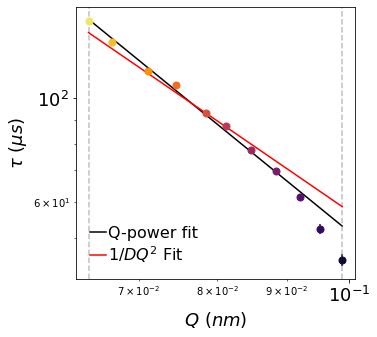

[0.09889776189283866, 0.095256660562808, 0.09212256818164052, 0.08839429637328979, 0.08475168369037077, 0.08113533563085039, 0.07851203940359536, 0.0745149872914487, 0.07111541054674533, 0.06688745273512944, 0.06427808621839916]


In [366]:
tau = np.array(tau) # us
tau_errors = np.array(tau_errors)
qq = np.array(qs)*1e9 # 1/m
x = qq # 1/m

if fun==1: 
    y = tau/unit # s
    yerr = tau_errors/unit # s
    print('fun 1')
elif fun==2: 
    kww = np.array(kww)
    kww_errors = np.array(kww_errors)
    y = (tau / kww * gamma(1/kww))/unit # s
    yerr = (tau_errors * np.abs(1/kww) + kww_errors * np.abs(-tau/kww**2 * gamma(1/kww) + tau/kww * -1/kww**2 * gamma(1/kww)*polygamma(0,1/kww)))/unit # s
    print('fun 2')

y_water = np.flip(y)
yerr_water = np.flip(yerr)
beta_water = np.flip(beta)
beta_water_errors = np.flip(beta_errors)

# fit range
a = 0
b = -1

################### fit log(tau) vs log(q) #######################

def tau_fit(x,a,b):
    return -a*x + b # q-dependence fit

fig, ax = plt.subplots(figsize=(5,5))

for i in range(len(x)):
    ax.errorbar(x[i]/1e9, y[i]*unit, yerr=yerr[i]*unit, fmt='o', ms=7, color=col[qind[i]])

popt, pcov = curve_fit(tau_fit, np.log(x[a:b]), np.log(y[a:b]), sigma=yerr[a:b]/y[a:b], p0=[2,1]) 
perr = np.sqrt(np.diag(pcov))
print('Q-exponent:',popt[0])
print(popt[1], popt[0]-2, np.exp(popt[1]*(popt[0]/2)))

xx = np.linspace(x[-1],x[0])
ax.plot(xx/1e9, np.exp(tau_fit(np.log(xx), *popt))*unit,'k-', lw=1.5, label=r'Q-power fit') 
ax.axvline(x[a]/1e9, ls='--', color='grey', alpha=0.5)
ax.axvline(x[b]/1e9, ls='--', color='grey', alpha=0.5) 

##################### fit tau vs q^-2 ####################

def tau_fit2(x,a):
    return (1/a)*x  

popt2, pcov2 = curve_fit(tau_fit2, 1/x[a:b]**(2), y[a:b], sigma=yerr[a:b], p0=[1e-12]) 
perr2 = np.sqrt(np.diag(pcov2)/1) # one g2 fit
D = popt2[0] # diffusion coefficient, m^2/s
Derr = perr2[0] # standard error
print('D:',D,'+-', Derr, 'm^2/s') 

xx = np.linspace(x[-1],x[0])
ax.plot(xx/1e9, tau_fit2(1/xx**(2), *popt2)*unit,'r-', lw=1.5, label=r'$1/DQ^2$ Fit')
ax.set_xlabel(r'$Q ~(nm)$', size=18)
ax.set_ylabel(r'$\tau ~(\mu s)$', size=18)
ax.tick_params(labelsize=18)
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend(frameon=False, loc='lower left', fontsize=16, labelspacing=0.2, handletextpad=0.1, handlelength=1)
plt.show()

#print([np.flip(x)/1e9, np.flip(y)*unit, np.flip(yerr)*unit])
#np.save('tau_data_water_simple_exp', [np.flip(x)/1e9, np.flip(y)*unit, np.flip(yerr)*unit])
#np.save('beta_data_water_simple_exp', [np.flip(x)/1e9, np.flip(np.array(beta)), np.flip(np.array(beta_errors))])

print(qs)

### Plot tau Q-dependence for paper

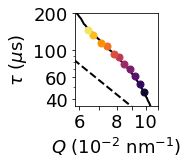

In [367]:
# import model values:
if solvent=='water':
    Q_av_tau = np.load('Q_av_tau_NPwater_simple_exp.npy')
    tau_av = np.load('tau_av_NPwater_simple_exp.npy')
    tau0_av = np.load('tau0_av_NPwater_simple_exp.npy')
elif solvent=='dmso':
    Q_av_tau = np.load('Q_av_tau_NPdmso_simple_exp.npy')
    tau_av = np.load('tau_av_NPdmso_simple_exp.npy')
    tau0_av = np.load('tau0_av_NPdmso_simple_exp.npy')

fig, ax = plt.subplots(figsize=(1.5,1.7))

for i in range(len(x)):
    ax.errorbar(x[i]/1e9*1e2, y[i]*unit, yerr=yerr[i]*unit, fmt='o', ms=7, color=col[qind[i]])

# convoluted model tau
plt.plot(Q_av_tau[:]*1e2,tau_av[:]*1e6, 'k-', lw=2, label=r'$\tau_{model, conv.}$') # color='dodgerblue',
plt.plot(Q_av_tau[:]*1e2,tau0_av[:]*1e6, 'k--', lw=2, label=r'$\tau_{model}$')

ax.set_xlabel(r'$Q$ ($10^{-2}$ nm$^{-1}$)', size=18)
ax.set_ylabel(r'$\tau$ ($\mu$s)', size=18)
ax.tick_params(labelsize=18)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([5, 6, 7, 8, 9, 10, 11, 12])
ax.set_xticklabels(['','6','','8','','10','','12'])
ax.set_yticks([30, 40, 60, 100, 200, 300])
ax.set_yticklabels(['','40','60','100', '200', ' '])
plt.xlim([5.8,11])
plt.ylim([3.5e1,2e2])

#plt.savefig('tau_'+sample+solvent+'_'+str(downsample)+'x'+str(downsample)+'_'+str(exp_time)+'s.png', dpi=300, bbox_inches='tight',) # save plot

plt.show()

### KWW exponent

### Viscosity for water and DMSO mixture

[1.35750647e-04 2.25528200e+02 1.65853387e+00]


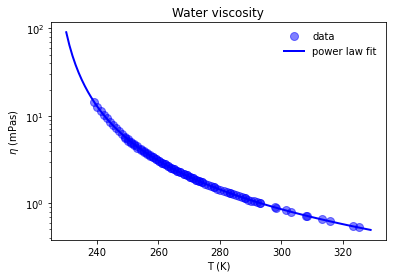

In [368]:
ndata_w1 = np.loadtxt('./viscositydata_dehaoui.dat', delimiter=',') # mPas, water viscosity from dehaoui et al.
ndata_w2 = np.loadtxt('./macroscopic_viscosity_water_hallet_kestin_collings.dat', delimiter=',') # mPas, macroscopic water viscosity 
ndata_w = np.vstack((ndata_w1,ndata_w2))

popt_w,pcov_w = fit(power_law,ndata_w[:,0],ndata_w[:,1]*1e-3,p0=[1e-4, 220, 2]) # power law fit, Pas
print(popt_w)

T_range = np.linspace(230,330,100) # K

plt.figure()
plt.plot(ndata_w[:,0],ndata_w[:,1],'o',c='b',alpha=0.5,ms=8,label='data')
plt.plot(T_range[0:-1],power_law(T_range[0:-1],*popt_w)*1e3,c='b',ls='-',lw=2 ,label='power law fit')
plt.xlabel(r'T (K)')
plt.ylabel(r'$\eta$ (mPas)')
plt.title(r'Water viscosity')
plt.legend(frameon=False)
plt.yscale('log')

#plt.savefig('water_viscosity.png') # save plot

plt.show()

[1.11734278e-03 1.61149938e+02 5.50173348e+00]
[3.57291777e-04 2.13028775e+02 2.56430758e+00]


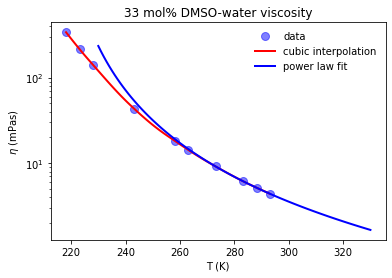

In [369]:
from scipy.interpolate import interp1d

# dmso/water viscosity
n_dmso = np.array([339.6, 214.7, 140.2, 43.47, 18.25, 14.27, 9.16, 6.17, 5.18, 4.383])*1e-3 # Pas, 33 mol% dmso
T_dmso = np.array([-55, -50, -45, -30, -15, -10, 0, 10, 15, 20])+273.15; # K 
# schichman, jpc 1971

f_dmso = interp1d(T_dmso, n_dmso, kind='cubic') # cubic interpolation
T_range = np.linspace(T_dmso[0], T_dmso[-1], num=100, endpoint=True)

plt.figure()
plt.plot(T_dmso,n_dmso*1e3,'o',c='b',alpha=0.5,ms=8,label='data')
plt.plot(T_range,f_dmso(T_range)*1e3,c='r',ls='-',lw=2 ,label='cubic interpolation')

# power law
popt_dmso_power,pcov_dmso_power = fit(power_law,T_dmso[6:],n_dmso[6:],p0=[1e-4, 200, 3]) # power law fit, Pas
print(popt_dmso_power)
TT_range = np.linspace(230,330,100) # K
plt.plot(TT_range,power_law(TT_range,*popt_dmso_power)*1e3,c='b',ls='-',lw=2 ,label='power law fit')

plt.xlabel(r'T (K)')
plt.ylabel(r'$\eta$ (mPas)')
plt.title(r'33 mol% DMSO-water viscosity')
plt.legend(frameon=False)
plt.yscale('log')

#plt.savefig('33dmso_viscosity.png') # save plot

plt.show()

### Estimate Rh

In [370]:
T = 295 # K
k = 1.38064852e-23

if solvent=='water':
    Rh = k*T/(6*np.pi*D*power_law(T,*popt_w))*1e9 # radius in nm, water
    Rh_err = k*T/(6*np.pi*power_law(T,*popt_w)) * 1/D**2 * Derr * 1e9
elif solvent=='dmso':           
    Rh = k*T/(6*np.pi*D*power_law(T,*popt_dmso_power))*1e9 # dmso-water
    Rh_err = k*T/(6*np.pi*power_law(T,*popt_dmso_power)) * 1/D**2 * Derr * 1e9

print(Rh, Rh_err)

129.25000559017295 2.102197222634434


## Compare different measurements

In [371]:
date = '2021-12-06'
datadir = './tmp/'+date+'/' # data directory

sample = '100NP_dmso'
scans = range(7587,7597)    # scans to run -- NP in water/DMSO in focus
exp_time = 5e-6             # exposure time [s]
downsample = 10             # pixel binning

filename = str(scans)+'_'+str(downsample)+'x'+str(downsample)+'_'+str(exp_time)+'s'

g2av1 = np.load(datadir+sample+'_g2av_'+filename+'.npy')
g2std1 = np.load(datadir+sample+'_g2std_'+filename+'.npy')
q1 = np.load(datadir+sample+'_q_'+filename+'.npy')
delays1 = np.load(datadir+sample+'_delays_'+filename+'.npy')

In [372]:
date = '2021-12-06'
datadir = './tmp/'+date+'/' # data directory

sample = '100NP_dmso'
scans = range(7607,7617)    # scans to run -- NP in water/DMSO 1000um out
exp_time = 5e-6             # exposure time [s]
downsample = 10             # pixel binning

filename = str(scans)+'_'+str(downsample)+'x'+str(downsample)+'_'+str(exp_time)+'s'

g2av2 = np.load(datadir+sample+'_g2av_'+filename+'.npy')
g2std2 = np.load(datadir+sample+'_g2std_'+filename+'.npy')
q2 = np.load(datadir+sample+'_q_'+filename+'.npy')
delays2 = np.load(datadir+sample+'_delays_'+filename+'.npy')

In [373]:
date = '2021-12-06'
datadir = './tmp/'+date+'/' # data directory

sample = '100NP_dmso'
scans = range(7637,7667)    # scans to run -- NP in water/DMSO 2000um out
exp_time = 5e-6             # exposure time [s]
downsample = 10             # pixel binning

filename = str(scans)+'_'+str(downsample)+'x'+str(downsample)+'_'+str(exp_time)+'s'

g2av3 = np.load(datadir+sample+'_g2av_'+filename+'.npy')
g2std3 = np.load(datadir+sample+'_g2std_'+filename+'.npy')
q3 = np.load(datadir+sample+'_q_'+filename+'.npy')
delays3 = np.load(datadir+sample+'_delays_'+filename+'.npy')

In [374]:
# put all measurements in a large matrix

g2av_dmso = np.empty((len(delays1),len(q1),3))
g2std_dmso = np.empty((len(delays1),len(q1),3))
q_dmso = q1 
delays = delays1

g2av_dmso[:,:,0] = g2av1 
g2av_dmso[:,:,1] = g2av2
g2av_dmso[:,:,2] = g2av3 

g2std_dmso[:,:,0] = g2std1 
g2std_dmso[:,:,1] = g2std2 
g2std_dmso[:,:,2] = g2std3 

# beam divergence
divergence = 1.2e-3 # divergence, rad
s1 = 88e-9 # focus size, m
distance = np.array([0, 1000e-6, 2000e-6])
beamsize = np.tan(divergence/2) * 2 * distance + s1 # beam size (fwhm) on detector, m
#beamsize = divergence * distance
beam = np.round(np.array([88, beamsize[1]*1e6, beamsize[2]*1e6]),1)
print('beam sizes:', beam)
beam_unit = ['nm','$\mu$m','$\mu$m']

alpha = [1, 0.5, 0.2]

print(g2av_dmso.shape, len(g2av_dmso[0,0,:]))

beam sizes: [88.   1.3  2.5]
(399, 20, 3) 3


## fit g2 vs beam size

553.3067267383598
597.8953567414477
568.3751293488594


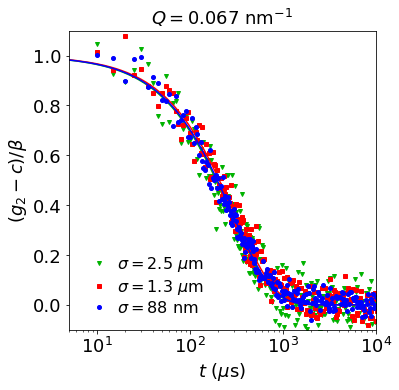

In [375]:
from scipy.special import gamma, polygamma
from scipy.optimize import curve_fit

fun = 1 # choose fit function
j = 3 # choose Q

if fun == 1:
    fit_func = exponential
elif fun==2:
    fit_func = stretched_exponential


plt.figure(figsize=(5.5,5.5)) # for paper

tstart = 1
tau = []
tau_errors = []
kww = []
kww_errors = []
qs = []
qind = []
unit = 1e6
t_dmso = delays*exp_time * unit # delay time [us]
tt = np.concatenate((np.linspace(0,1,10), np.logspace(0,5,200).astype(int)), axis=None)*1e-6*unit
symbol = ['o','s','v']
col = ['b','r',[0,0.7,0]]

for i in [2, 1, 0]:
    
    bg = np.mean(g2av_dmso[300:,j,i])
    
    # Data range to fit
    tend=tstart
    while (g2av_dmso[tend, j, i]-bg) > (g2av_dmso[tstart, j, i]-bg)*1/3: 
        tend+=1 
    tend=-1
   
    if fun == 1: # simple exponential fit
        popt, pcov = curve_fit(fit_func, t_dmso[tstart:tend], g2av_dmso[tstart:tend, j, i]-bg, sigma=g2std_dmso[tstart:tend, j, i], p0=[0.3, 100], bounds=((0,0),(np.inf,np.inf)))
        perr = np.sqrt(np.diag(pcov))
        print(popt[1])
    elif fun==2: # kww exponential fit
        popt, pcov = curve_fit(fit_func, t_dmso[tstart:tend], g2av_dmso[tstart:tend, j, i]-bg, sigma=g2std_dmso[tstart:tend, j, i], p0=[0.3, 100, 1], bounds=((0,0,0),(np.inf,np.inf,2)))
        perr = np.sqrt(np.diag(pcov))
        kww.append(popt[2])
        kww_errors.append(perr[2])
        print(popt[1], popt[2])
    
    tau.append(popt[1])
    tau_errors.append(perr[1])
    qs.append(q_dmso[i])
    qind.append(i)
    
    if i==0:
        l, = plt.plot(t_dmso[1:], (g2av_dmso[1:, j, i]-bg)/popt[0], symbol[i], color=col[i], ms=4 , label=r'$\sigma = %.d$ nm' %(beam[i]))
    else:
        l, = plt.plot(t_dmso[1:], (g2av_dmso[1:, j, i]-bg)/popt[0], symbol[i], color=col[i], ms=4 , label=r'$\sigma = %.1f$ $\mu$m' %(beam[i]))
    plt.plot(tt, fit_func(tt, *popt)/popt[0], color=l.get_color(), linestyle='-', lw=1.5)
    
#plt.plot(np.array([t[tend], t[tend]]), [-0.1, 0.6],'-', c='k') # plot vertical line marking the end of the fit range

plt.xlabel('$t$ ($\mu$s)', size=18)
#plt.ylabel(r'$g_2-c$', size=18)
#plt.ylabel(r'$g_2$ (norm.)', size=18)
plt.ylabel(r'$(g_2-c)/\beta$', size=18)
plt.xscale('log', nonpositive='clip')
plt.legend(frameon=False, loc='lower left', fontsize=16, labelspacing=0.2, handletextpad=0.1)
plt.tick_params(labelsize=18)
plt.title(r'$Q = %.3f$ nm$^{-1}$' %q_dmso[j], size=18)
plt.xlim([5e-6*unit,1e-2*unit])
plt.ylim([-0.1,1.1])

#plt.savefig('g2fit_beam_size_dmso_'+str(downsample)+'x'+str(downsample)+'_'+str(exp_time)+'s.png', dpi=200, bbox_inches='tight',)# save plot

plt.show()

### with contrast

568.3751293488594
0.3722661229103264 1.0525580548241575
597.8953567414477
0.2437053519700982 1.0452484070016408
553.3067267383598
0.1374791928673458 1.038369124894526


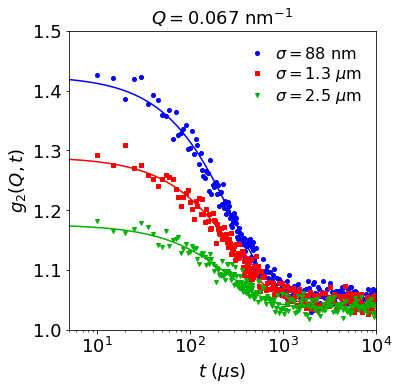

In [376]:
plt.figure(figsize=(5.5,5.5)) # for paper

tstart = 1
tau = []
tau_errors = []
kww = []
kww_errors = []
qs = []
qind = []
beta = []
unit = 1e6
t_dmso = delays*exp_time * unit # delay time [us]
tt = np.concatenate((np.linspace(0,1,10), np.logspace(0,5,200).astype(int)), axis=None)*1e-6*unit
symbol = ['o','s','v']
col = ['b','r',[0,0.7,0]]


for i in [0, 1, 2]:
    
    bg = np.mean(g2av_dmso[300:,j,i])
    
    # Data range to fit
    tend=tstart
    while (g2av_dmso[tend, j, i]-bg) > (g2av_dmso[tstart, j, i]-bg)*1/3: 
        tend+=1 
    tend=-1
   
    if fun == 1: # simple exponential fit
        popt, pcov = curve_fit(fit_func, t_dmso[tstart:tend], g2av_dmso[tstart:tend, j, i]-bg, sigma=g2std_dmso[tstart:tend, j, i], p0=[0.3, 100], bounds=((0,0),(np.inf,np.inf)))
        perr = np.sqrt(np.diag(pcov))
        print(popt[1])
    elif fun==2: # kww exponential fit
        popt, pcov = curve_fit(fit_func, t_dmso[tstart:tend], g2av_dmso[tstart:tend, j, i]-bg, sigma=g2std_dmso[tstart:tend, j, i], p0=[0.3, 100, 1], bounds=((0,0,0),(np.inf,np.inf,2)))
        perr = np.sqrt(np.diag(pcov))
        kww.append(popt[2])
        kww_errors.append(perr[2])
        print(popt[1], popt[2])
    
    beta.append(popt[0])
    tau.append(popt[1])
    tau_errors.append(perr[1])
    qs.append(q_dmso[i])
    qind.append(i)
    print(popt[0], bg)
    
    if i==0:
        l, = plt.plot(t_dmso[1:], (g2av_dmso[1:, j, i]), symbol[i], color=col[i], ms=4 , label=r'$\sigma = %.d$ nm' %(beam[i]))
    else:
        l, = plt.plot(t_dmso[1:], (g2av_dmso[1:, j, i]), symbol[i], color=col[i], ms=4 , label=r'$\sigma = %.1f$ $\mu$m' %(beam[i]))
    plt.plot(tt, fit_func(tt, *popt)+bg, color=l.get_color(), linestyle='-', lw=1.5)
    
#plt.plot(np.array([t[tend], t[tend]]), [-0.1, 0.6],'-', c='k') # plot vertical line marking the end of the fit range

plt.xlabel('$t$ ($\mu$s)', size=18)
plt.ylabel(r'$g_2(Q,t)$', size=18)
plt.xscale('log', nonpositive='clip')
#plt.legend(frameon=False, loc='lower left', fontsize=16, labelspacing=0.2, handletextpad=0.1, bbox_to_anchor=[-0.05,-0.02])
plt.legend(frameon=False, loc='upper right', fontsize=16, labelspacing=0.2, handletextpad=0.1)
plt.tick_params(labelsize=18)
plt.title(r'$Q = %.3f$ nm$^{-1}$' %q_dmso[j], size=18)
plt.xlim([5e-6*unit,1e-2*unit])
plt.ylim([1.0,1.5])

#plt.savefig('g2fit_contrast_beam_size_dmso_'+str(downsample)+'x'+str(downsample)+'_'+str(exp_time)+'s.png', dpi=200, bbox_inches='tight')# save plot

plt.show()

### contrast vs beam size

[5.63564514 0.38504403 0.19933148] [10.24662752  0.70008006  0.36242087]
contrast [0.3722661229103264, 0.2437053519700982, 0.1374791928673458]


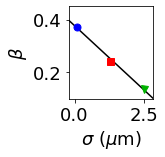

In [377]:
L=4.0 # sample-detector distance, m
b=np.linspace(-1,3e-6,100) # beam sizes for plotting fit, m
speckle_size = wavelength*L/beamsize
sp = speckle_size/(pix*10)
print(speckle_size*1e3, sp)
print('contrast',beta)

def line(x, a, b):
    return a*x+b
    
popt, pcov = curve_fit(line, beamsize, beta)

fig, ax = plt.subplots(figsize=(1.5,1.7))

ax.plot(b*1e6, line(b,*popt),'k-')

for i in range(3):
    
    ax.plot(beamsize[i]*1e6, beta[i], symbol[i], color=col[i], ms=7)
    
ax.set_xlabel(r'$\sigma$ ($\mu$m)', size=18)
ax.set_ylabel(r'$\beta$', size=18)
ax.tick_params(labelsize=18)
ax.set_xlim([-0.2, 2.8])
ax.set_ylim([0.1, 0.45])
#ax.set_xscale('log')
#ax.set_yscale('log')

#plt.savefig('contrast_beam.png', dpi=300, bbox_inches='tight')

plt.show()

## fit all Q:s and beam sizes

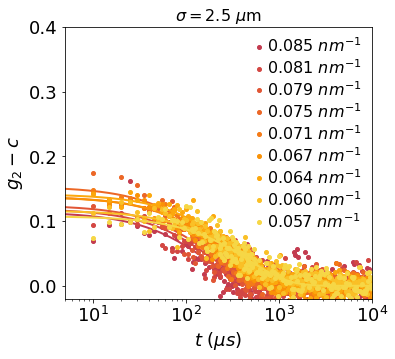

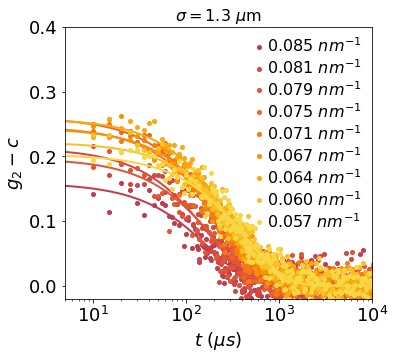

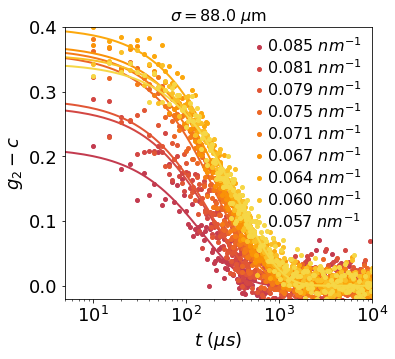

[[766.51390786 884.47510362 950.54531318]
 [719.93032132 798.99438707 823.77544162]
 [634.10388454 658.93585975 684.54012488]
 [568.37577189 597.89379288 553.30630503]
 [502.11719631 511.15100534 519.6070988 ]
 [456.43259996 487.05651052 448.10524963]
 [385.83396887 407.96955375 397.14456167]
 [383.70506018 362.56380787 372.24241936]
 [310.66640194 357.03087681 323.09459291]] [[0.05676936 0.05676936 0.05676936]
 [0.06032793 0.06032793 0.06032793]
 [0.06427809 0.06427809 0.06427809]
 [0.06688745 0.06688745 0.06688745]
 [0.07111541 0.07111541 0.07111541]
 [0.07451499 0.07451499 0.07451499]
 [0.07851204 0.07851204 0.07851204]
 [0.08113534 0.08113534 0.08113534]
 [0.08475168 0.08475168 0.08475168]]


In [378]:
N = 11 # no of high q values to exclude

sample = ['100NP_dmso_88','100NP_dmso_1300','100NP_dmso_2300']

tstart = 1
col = plt.cm.inferno_r(np.linspace(0.1,1,len(q_dmso)))
tau = np.empty((len(q_dmso)-N,3))
tau_errors = np.empty((len(q_dmso)-N,3))
kww =np.empty((len(q_dmso)-N,3))
kww_errors = np.empty((len(q_dmso)-N,3))
beta = np.empty((len(q_dmso)-N,3))
beta_errors = np.empty((len(q_dmso)-N,3))
qs = np.empty((len(q_dmso)-N,3))

for i in [2, 1, 0]:
    
    plt.figure(figsize=(5.5,5)) 
    
    for j in range(len(q_dmso)-N-1,-1,-1):
    
        bg = np.mean(g2av_dmso[300:, j, i])
        
        # Data range to fit:
        tend=tstart
        while (g2av_dmso[tend, j, i]-bg) > (g2av_dmso[tstart, j, i]-bg)*1/3: 
            tend+=1 
        tend=-1
   
        if fun == 1: # simple exponential fit
            popt, pcov = curve_fit(fit_func, t_dmso[tstart:tend], g2av_dmso[tstart:tend, j, i]-bg, sigma=g2std_dmso[tstart:tend, j, i], p0=[0.3, 300], bounds=((0,0),(np.inf,np.inf)))
        elif fun==2: # kww exponential fit
            popt, pcov = curve_fit(fit_func, t_dmso[tstart:tend], g2av_dmso[tstart:tend, j, i]-bg, sigma=g2std_dmso[tstart:tend, j, i], p0=[0.3, 300, 1], bounds=((0,0,0),(np.inf,np.inf,2)))
        perr = np.sqrt(np.diag(pcov))
    
        tau[j, i] = popt[1]
        tau_errors[j, i] = perr[1]
        beta[j, i] = popt[0]
        beta_errors[j, i] = perr[0]
        if fun == 2:
            kww[j, i] = popt[2]
            kww_errors [j, i] = perr[2]
        qs[j, i] = q_dmso[j]

        plt.plot(t_dmso[1:], (g2av_dmso[1:, j, i]-bg), 'o', ms=4 , color=col[j], label=r'%.3f $nm^{-1}$' %q_dmso[j]) # normalized r'
        plt.plot(tt, (fit_func(tt, *popt)), color=col[j], linestyle='-', lw=2) # normalized
    
        plt.xlabel('$t ~(\mu s)$', size=18)
        plt.ylabel(r'$g_2-c$', size=18)
        plt.xscale('log', nonpositive='clip')
        plt.legend(frameon=False, loc='upper right', fontsize=16, labelspacing=0.2, handletextpad=0.0, handlelength=1.0, borderpad=0.1)
        plt.tick_params(labelsize=18)
        plt.xlim([5e-6*unit,1e-2*unit])
        plt.ylim([-0.02,0.4])
        plt.title('$\sigma = %.1f$ $\mu$m' %(beam[i]), size=16)

        #plt.savefig('g2fit_'+sample[i]+'_'+str(downsample)+'x'+str(downsample)+'_'+str(exp_time)+'s.png', dpi=300, bbox_inches='tight')# save plot

plt.show()

print(tau, qs)

### plot fitted taus vs q and beam size

[  0.         16.        109.7209375] [  0.         16.        109.7209375] 0.0


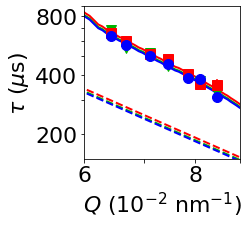

In [379]:
x = qs[2:,:] 
if fun==1:
    y = tau[2:,:]/unit # s
    yerr = tau_errors[2:,:]/unit # s
elif fun==2:
    y = (tau[2:,:] / kww[2:,:] * gamma(1/kww[2:,:]))/unit # s
    yerr = (tau_errors[2:,:] * np.abs(1/kww[2:,:]) + kww_errors[2:,:] * np.abs(-tau[2:,:]/kww[2:,:]**2 * gamma(1/kww[2:,:]) + tau[2:,:]/kww[2:,:] * -1/kww[2:,:]**2 * gamma(1/kww[2:,:])*polygamma(0,1/kww[2:,:])))/unit # s
    kwws = kww[2:,:]
    kwws_err = kww_errors[2:,:]
    
y_dmso = y
yerr_dmso = yerr
beta_dmso = beta[2:,:]
beta_dmso_err = beta_errors[2:,:]

#print([x, y*unit, yerr*unit])
#np.save('tau_data_dmso_simple_exp', [x, y*unit, yerr*unit])
#np.save('beta_data_dmso_simple_exp', [qs, np.array(beta), np.array(beta_errors)])

D = np.empty((3))
Derr = np.empty((3))

def tau_fit(x,a):
    return (1/a)*x 

#########################################
#fig, ax = plt.subplots(figsize=(1.5,1.7))
fig, ax = plt.subplots(1, 1, figsize=(2.8,2.8))

col = ['b','r',[0,0.7,0]]

for i in [2, 1, 0]:
    
    for j in range(len(x)):
        ax.errorbar(x[j,i]*1e2, y[j,i]*unit, yerr=yerr[j,i]*unit, fmt=symbol[i], ms=10, color=col[i])

    # convoluted model tau
    fname = 'NPdmso_'+str(i)+'_simple_exp.npy'
    Q_av_tau = np.load('Q_av_tau_'+fname)
    tau_av = np.load('tau_av_'+fname) # convoluted model
    tau0_av = np.load('tau0_av_'+fname) # model without convolution
    plt.plot(Q_av_tau*1e2,tau_av*unit, '-', lw=2, color=col[i], label=r'$\tau_{model, conv.}$') # color='dodgerblue',
    plt.plot(Q_av_tau*1e2,tau0_av*unit, '--', lw=2, color=col[i], label=r'$\tau_{model}$')
    
ax.set_xlabel(r'$Q$ ($10^{-2}$ nm$^{-1}$)', size=22)
ax.set_ylabel(r'$\tau$ ($\mu$s)', size=22)
ax.tick_params(labelsize=22)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([5, 6, 7, 8, 9, 10, 11, 12])
ax.set_xticklabels(['','6','','8','','10','','12'])
ax.set_yticks([200,300,400,500,600,700,800,900,1000])
ax.set_yticklabels(['200','','400','','','','800','',''])
plt.xlim([6,9])
plt.ylim([150,900])

#plt.savefig('tau_'+'dmso'+solvent+'_'+str(downsample)+'x'+str(downsample)+'_'+str(exp_time)+'s.png', dpi=300, bbox_inches='tight',) # save plot

print(D, Derr, Q_av_tau[0])
plt.show()

### kww exponents

# save data

In [380]:
#!{sys.executable} -m pip install astropy
from astropy.io import ascii
from astropy.table import Table, Column, MaskedColumn

### g2 NP in water

In [395]:
tab = Table()

qlength=len(q[2:len(q)-7])
arr = np.empty((len(t)-1-qlength))
arr[:] = np.NaN

tab['q'] = np.append(q[2:len(q)-7], arr) 
tab['tau'] = np.append(y_water*1e6, arr)         
tab['tau_err'] = np.append(yerr_water*1e6, arr)  
tab['beta'] = np.append(beta_water, arr) 
tab['beta_err'] = np.append(beta_water_errors, arr) 
tab['t'] = t[1:] 

j=0
for i in range(2,len(q)-7):
    tab['g2_'+str(j)] = g2av[1:, i]
    tab['g2_stdev_'+str(j)] = g2std[1:, i]
    j+=1
    
j=0
format_dict = {'q': '%.6f'}
format_dict = {'tau': '%.6f'}
format_dict = {'tau_err': '%.6f'}
format_dict = {'beta': '%.6f'}
format_dict = {'beta_err': '%.6f'}
format_dict = {'t': '%.6f'}
for i in range(2,len(q)-7):
    format_dict['g2_'+str(j)] = '%.6f'
    format_dict['g2_stdev_'+str(j)] = '%.6f'
    j+=1
    
tab.meta['comments'] = {'This file was created Wed 29 Jun 2022 \n'
                      '# Created by Sharon Berkowicz \n'
                      '# \n'
                      '# Description: Average intensity autocorrelation g2 functions versus lag time at different momentum transfers for 100 nm silica nanoparticles (NP) in water. \n'
                      '# \n'
                      '# Sample position:  Focal plane \n'
                      '# \n'
                      '# Momentum transfer q [nm^-1] \n'
                      '# Time constant tau [microseconds] \n'
                      '# Contrast beta \n'
                      '# Lag time t [microseconds] \n'
                      '# average g2 at different q \n'
                      '# \n'
                     }

ascii.write(tab, 'g2_NPwater.dat', overwrite=True, format='fixed_width', delimiter=' ', formats=format_dict) #, fill_values = [('nan', '-')])
ascii.FixedWidth(col_starts=None, col_ends=None, delimiter_pad=' ', bookend=True)


## g2 NP in dmso

### in focus

In [397]:
tab = Table()

qlength=len(q[2:len(q1)-11])
arr = np.empty((len(t)-1-qlength))
arr[:] = np.NaN

tab['q'] = np.append(q1[2:len(q1)-11], arr) 
tab['tau'] = np.append(y_dmso[:,0]*1e6, arr)         
tab['tau_err'] = np.append(yerr_dmso[:,0]*1e6, arr)  
tab['beta'] = np.append(beta_dmso[:,0], arr) 
tab['beta_err'] = np.append(beta_dmso_err[:,0], arr) 
tab['t'] = t[1:] 

j=0
for i in range(2,len(q1)-11):
    tab['g2_'+str(j)] = g2av1[1:, i]
    tab['g2_stdev_'+str(j)] = g2std1[1:, i]
    j+=1
    
j=0
format_dict = {'q': '%.6f'}
format_dict = {'tau': '%.6f'}
format_dict = {'tau_err': '%.6f'}
format_dict = {'beta': '%.6f'}
format_dict = {'beta_err': '%.6f'}
format_dict = {'t': '%.6f'}
for i in range(2,len(q1)-11):
    format_dict['g2_'+str(j)] = '%.6f'
    format_dict['g2_stdev_'+str(j)] = '%.6f'
    j+=1
    
tab.meta['comments'] = {'This file was created Wed 29 Jun 2022 \n'
                      '# Created by Sharon Berkowicz \n'
                      '# \n'
                      '# Description: Average intensity autocorrelation g2 functions versus lag time at different momentum transfers for 100 nm silica nanoparticles (NP) in 33 mol% dmso-water solution. \n'
                      '# \n'
                      '# Sample position:  Focal plane \n'
                      '# \n'
                      '# Momentum transfer q [nm^-1] \n'
                      '# Time constant tau [microseconds] \n'
                      '# Contrast beta \n'
                      '# Lag time t [microseconds] \n'
                      '# average g2 at different q \n'
                      '# \n'
                     }

ascii.write(tab, 'g2_NPdmso_1.dat', overwrite=True, format='fixed_width', delimiter=' ', formats=format_dict) 
ascii.FixedWidth(col_starts=None, col_ends=None, delimiter_pad=' ', bookend=True)


### 1 mm out

In [398]:
tab = Table()

qlength=len(q[2:len(q2)-11])
arr = np.empty((len(t)-1-qlength))
arr[:] = np.NaN

tab['q'] = np.append(q2[2:len(q2)-11], arr) 
tab['tau'] = np.append(y_dmso[:,1]*1e6, arr)         
tab['tau_err'] = np.append(yerr_dmso[:,1]*1e6, arr)  
tab['beta'] = np.append(beta_dmso[:,1], arr) 
tab['beta_err'] = np.append(beta_dmso_err[:,1], arr) 
tab['t'] = t[1:] 

j=0
for i in range(2,len(q1)-11):
    tab['g2_'+str(j)] = g2av2[1:, i]
    tab['g2_stdev_'+str(j)] = g2std2[1:, i]
    j+=1
    
j=0
format_dict = {'q': '%.6f'}
format_dict = {'tau': '%.6f'}
format_dict = {'tau_err': '%.6f'}
format_dict = {'beta': '%.6f'}
format_dict = {'beta_err': '%.6f'}
format_dict = {'t': '%.6f'}
for i in range(2,len(q2)-11):
    format_dict['g2_'+str(j)] = '%.6f'
    format_dict['g2_stdev_'+str(j)] = '%.6f'
    j+=1
    
tab.meta['comments'] = {'This file was created Wed 29 Jun 2022 \n'
                      '# Created by Sharon Berkowicz \n'
                      '# \n'
                      '# Description: Average intensity autocorrelation g2 functions versus lag time at different momentum transfers for 100 nm silica nanoparticles (NP) in 33 mol% dmso-water solution. \n'
                      '# \n'
                      '# Sample position:  1000 um out \n'
                      '# \n'
                      '# Momentum transfer q [nm^-1] \n'
                      '# Time constant tau [microseconds] \n'
                      '# Contrast beta \n'
                      '# Lag time t [microseconds] \n'
                      '# average g2 at different q \n'
                      '# \n'
                     }

ascii.write(tab, 'g2_NPdmso_2.dat', overwrite=True, format='fixed_width', delimiter=' ', formats=format_dict) 
ascii.FixedWidth(col_starts=None, col_ends=None, delimiter_pad=' ', bookend=True)

### 2 mm out

In [399]:
tab = Table()

qlength=len(q[2:len(q1)-11])
arr = np.empty((len(t)-1-qlength))
arr[:] = np.NaN

tab['q'] = np.append(q3[2:len(q3)-11], arr) 
tab['tau'] = np.append(y_dmso[:,2]*1e6, arr)         
tab['tau_err'] = np.append(yerr_dmso[:,2]*1e6, arr)  
tab['beta'] = np.append(beta_dmso[:,2], arr) 
tab['beta_err'] = np.append(beta_dmso_err[:,2], arr) 
tab['t'] = t[1:] 

j=0
for i in range(2,len(q3)-11):
    tab['g2_'+str(j)] = g2av3[1:, i]
    tab['g2_stdev_'+str(j)] = g2std3[1:, i]
    j+=1
    
j=0
format_dict = {'q': '%.6f'}
format_dict = {'tau': '%.6f'}
format_dict = {'tau_err': '%.6f'}
format_dict = {'beta': '%.6f'}
format_dict = {'beta_err': '%.6f'}
format_dict = {'t': '%.6f'}
for i in range(2,len(q3)-11):
    format_dict['g2_'+str(j)] = '%.6f'
    format_dict['g2_stdev_'+str(j)] = '%.6f'
    j+=1
    
tab.meta['comments'] = {'This file was created Wed 29 Jun 2022 \n'
                      '# Created by Sharon Berkowicz \n'
                      '# \n'
                      '# Description: Average intensity autocorrelation g2 functions versus lag time at different momentum transfers for 100 nm silica nanoparticles (NP) in 33 mol% dmso-water solution. \n'
                      '# \n'
                      '# Sample position:  Focal plane \n'
                      '# \n'
                      '# Momentum transfer q [nm^-1] \n'
                      '# Time constant tau [microseconds] \n'
                      '# Contrast beta \n'
                      '# Lag time t [microseconds] \n'
                      '# average g2 at different q \n'
                      '# \n'
                     }

ascii.write(tab, 'g2_NPdmso_3.dat', overwrite=True, format='fixed_width', delimiter=' ', formats=format_dict) 
ascii.FixedWidth(col_starts=None, col_ends=None, delimiter_pad=' ', bookend=True)